In [1]:
import torch
from utils import process_dataset
from argparse import ArgumentParser
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import numpy as np
import random

seed = 123
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

/home/vincent0730/ML_pondlet_level_predictor/venv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# datasets = "../datasets/pondlet_gloss_HSK3_2021-all.csv;../datasets/pondlet_STB_HSK3_2021-all.csv"
datasets = "../datasets/pondlet_STB_HSK3_2021-all.csv"
balance_data = process_dataset(datasets)
balance_data.drop("ID", inplace=True, axis=1)
#balance_data.drop("None", inplace=True, axis=1)
#balance_data.drop("7-9", inplace=True, axis=1)

datasets ../datasets/pondlet_STB_HSK3_20220429_new.csv
len-balance_data(one) 1616


In [3]:
balance_data.head()

,Label,Length,1,2,3,4,5,6,7-9,None
0,Lv.1,100,48,3,10,0,0,0,8,1
1,Lv.4,314,107,39,12,13,5,4,22,0
2,Lv.1,38,24,0,0,0,0,0,0,0
3,Lv.6,610,166,63,58,36,12,27,24,5
4,Lv.3,253,85,30,6,4,9,2,4,8


In [4]:
X = balance_data.iloc[:, 1:].to_numpy()

le = preprocessing.LabelEncoder()
le.fit(balance_data.Label)
balance_data['categorical_label'] = le.transform(balance_data.Label)
y = balance_data.iloc[:, -1].to_numpy()


# ['Lv.1' 'Lv.2' 'Lv.3' 'Lv.4' 'Lv.5' 'Lv.6']
print(le.classes_)


X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.1, stratify=y_tmp, random_state=42)

['Lv.1' 'Lv.2' 'Lv.3' 'Lv.4' 'Lv.5' 'Lv.6']


In [5]:
le.inverse_transform([y_tmp[0]])

array(['Lv.3'], dtype=object)

In [6]:
le.classes_.tolist()

['Lv.1', 'Lv.2', 'Lv.3', 'Lv.4', 'Lv.5', 'Lv.6']

In [7]:
import torch
import torch.nn.functional as F
import torch.nn as nn

In [8]:
class Model(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 8)
        self.layer2 = nn.Linear(8, 16)
        self.layer3 = nn.Linear(16, output_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))        
        return self.layer3(x)


In [60]:
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):        
        return self.x[idx], self.y[idx]

In [61]:
from torch.utils.data import DataLoader

X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)
test = CustomDataset(X_test, y_test)
test_dataloader = DataLoader(test, batch_size=8, shuffle=True)

In [62]:
loss_fn   = nn.CrossEntropyLoss()

In [63]:
def train_one_epoch(train_dataloader, model, optimizer):

    train_correct = 0
    train_total = 0
    train_loss = 0.0

    for i, data in enumerate(train_dataloader, 0):

        inputs, labels = data

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        values, indices = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (indices == labels).sum().item()

    acc = 100 * train_correct / train_total
    loss = train_loss / len(train_dataloader)
    return acc, loss

In [64]:
def val_one_epoch(val_dataloader, model):

    val_correct = 0
    val_total = 0
    val_loss = 0

    with torch.no_grad():

        for data in val_dataloader:

            inputs, labels = data
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            values, indices = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (indices == labels).sum().item()

    acc = 100 * val_correct / val_total
    loss = val_loss / len(val_dataloader)
    return acc, loss

In [65]:
def test_at_final(test_dataloader, model):

    test_correct = 0
    test_total = 0
    y_true, y_pred = [], []
    
    with torch.no_grad():

        for data in test_dataloader:

            inputs, labels = data
            outputs = model(inputs)
            values, indices = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (indices == labels).sum().item()

            y_true.extend(labels.tolist())
            y_pred.extend(indices.tolist())

    acc = 100 * test_correct / test_total
    array = confusion_matrix(y_true, y_pred)
    return acc, array

In [66]:
X_tmp.shape, X_test.shape

((1454, 9), torch.Size([162, 9]))

In [76]:
X_train.shape[1], len(le.classes_)

(9, 6)

In [77]:
X_train[0]

tensor([442., 118.,  54.,  18.,  16.,   5.,   1.,   4.,  77.])

In [67]:
skf = StratifiedKFold(n_splits=4, random_state=seed, shuffle=True)
kfold_train_acc = []
kfold_val_acc = []
kfold_test_acc = []
cf_arrays = []

for i, (train_index, val_index) in enumerate(skf.split(X_tmp, y_tmp)):
    X_train, X_val = X_tmp[train_index], X_tmp[val_index]
    y_train, y_val = y_tmp[train_index], y_tmp[val_index]

    X_train = torch.FloatTensor(X_train)
    X_val = torch.FloatTensor(X_val)
    y_train = torch.LongTensor(y_train)
    y_val = torch.LongTensor(y_val)

    train = CustomDataset(X_train, y_train)
    val = CustomDataset(X_val, y_val)

    train_dataloader = DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val, batch_size=8, shuffle=True)

    model     = Model(X_train.shape[1], len(le.classes_))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []

    for epoch in tqdm(range(500)):
        train_acc, train_loss = train_one_epoch(train_dataloader, model, optimizer)
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)

        val_acc, val_loss = val_one_epoch(val_dataloader, model)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)
    
    test_acc, cf_array = test_at_final(test_dataloader, model)
    cf_arrays.append(cf_array)

    kfold_train_acc.append(np.mean(train_acc_list))
    kfold_val_acc.append(np.mean(val_acc_list))
    kfold_test_acc.append(test_acc)
    torch.save(model.state_dict(), f"model_fold{i}.pt")


100%|██████████| 500/500 [01:20<00:00,  6.18it/s]


In [68]:
kfold_train_acc

[68.21357798165138, 70.21155963302753, 68.31475710357469, 66.57836846929422]

In [69]:
kfold_val_acc

[63.98571428571429, 67.24120879120879, 62.617079889807165, 65.80055096418734]

In [70]:
kfold_test_acc

[69.75308641975309, 70.37037037037037, 65.4320987654321, 70.37037037037037]

In [71]:
labels, counts = np.unique(y_test, return_counts=True)
for l, c in zip(labels, counts):
    print(f"Lable:{l}, Count:{c}")

Lable:0, Count:14
Lable:1, Count:15
Lable:2, Count:28
Lable:3, Count:62
Lable:4, Count:30
Lable:5, Count:13


In [72]:
print(f"Baseline acc:{100*counts.max()/counts.sum():.2f}")
print(f"4 folds  acc:{np.mean(kfold_test_acc):.2f}")

Baseline acc:38.27
4 folds  acc:68.98


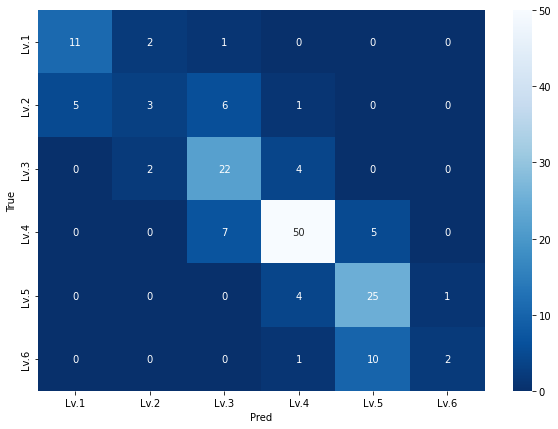

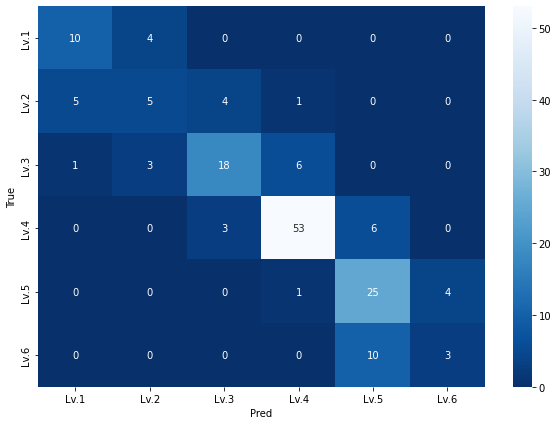

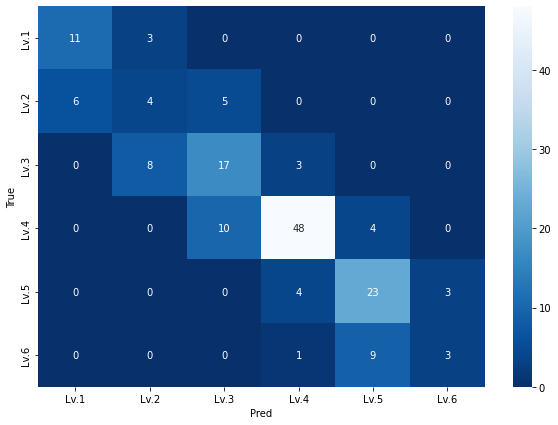

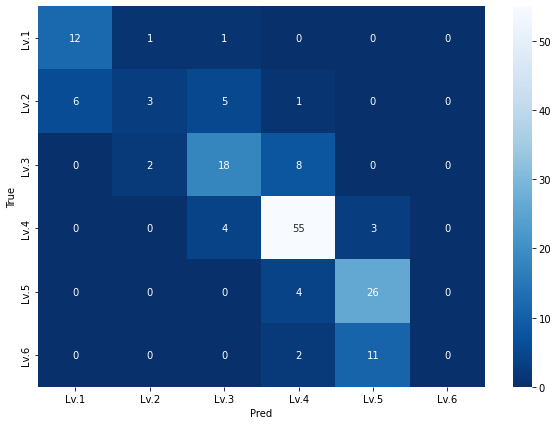

In [73]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


for array in cf_arrays:
    df_cm = pd.DataFrame(array, index = le.classes_.tolist(),
                    columns = le.classes_.tolist())
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, cmap="Blues_r")
    plt.xlabel('Pred')
    plt.ylabel('True')
    plt.show();

In [ ]:
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in tqdm(range(500)):  # loop over the dataset multiple times

    train_correct = 0
    train_total = 0
    train_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):

        inputs, labels = data

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        values, indices = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (indices == labels).sum().item()

    train_acc_list.append(100 * train_correct // train_total)
    train_loss_list.append(train_loss / len(train_dataloader))

    val_correct = 0
    val_total = 0
    val_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels = data
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            values, indices = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (indices == labels).sum().item()

    val_acc_list.append(100 * val_correct // val_total)
    val_loss_list.append(val_loss / len(val_dataloader))

print('Finished Training')

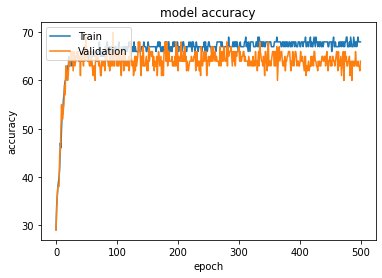

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_acc_list)
plt.plot(val_acc_list)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

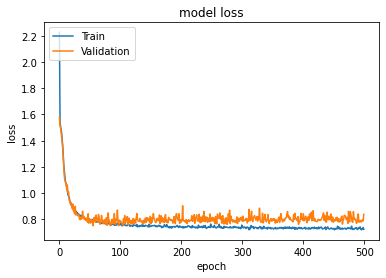

In [ ]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_correct = 0
test_total = 0
y_true, y_pred = [], []
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        outputs = model(inputs)
        values, indices = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (indices == labels).sum().item()
        
        y_true.extend(labels.tolist())
        y_pred.extend(indices.tolist())

print(f'Accuracy: {100 * test_correct / test_total} %')
print("test_correct", test_correct)
print("test_total", test_total)

Accuracy: 68.96551724137932 %
test_correct 120
test_total 174


In [ ]:
from sklearn.metrics import confusion_matrix

array = confusion_matrix(y_true, y_pred)

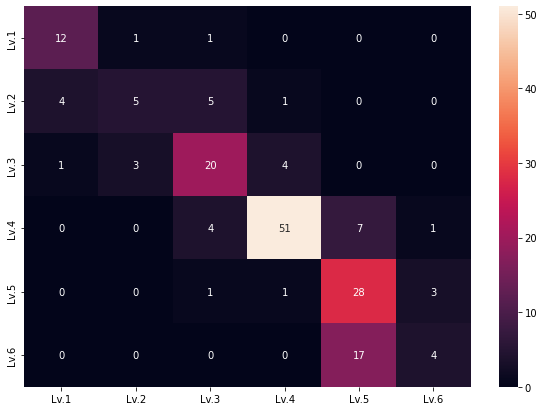

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(array, index = le.classes_.tolist(),
                  columns = le.classes_.tolist())
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show();

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=le.classes_.tolist()))

              precision    recall  f1-score   support

        Lv.1       0.71      0.86      0.77        14
        Lv.2       0.56      0.33      0.42        15
        Lv.3       0.65      0.71      0.68        28
        Lv.4       0.89      0.81      0.85        63
        Lv.5       0.54      0.85      0.66        33
        Lv.6       0.50      0.19      0.28        21

   micro avg       0.69      0.69      0.69       174
   macro avg       0.64      0.63      0.61       174
weighted avg       0.69      0.69      0.67       174



In [ ]:
class BinaryModel(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(BinaryModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 8)
        self.layer2 = nn.Linear(8, 16)
        self.layer3 = nn.Linear(16, output_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))        
        return self.layer3(x)

class CLSModel(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(CLSModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 4)
        self.layer2 = nn.Linear(4, 8)
        self.layer3 = nn.Linear(8, output_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))        
        return self.layer3(x)

In [ ]:
binary_model = BinaryModel(input_dim=9, output_dim=1)
binary_model.load_state_dict(torch.load("./binary.pt"))
binary_model.eval()

cls123_model = CLSModel(input_dim=9, output_dim=3)
cls123_model.load_state_dict(torch.load("./cls123.pt"))
cls123_model.eval()

cls456_model = CLSModel(input_dim=9, output_dim=3)
cls456_model.load_state_dict(torch.load("./cls456.pt"))
cls456_model.eval()

model.eval()

Model(
  (layer1): Linear(in_features=9, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=6, bias=True)
)

In [ ]:
test_correct = 0
test_total = 0

cls456_mapping = {0:3, 1:4, 2:5}
cls123_mapping = {0:0, 1:1, 2:2}
y_true_list, y_pred_list = [], []

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        outputs = binary_model(inputs)
        cls456_outputs = cls456_model(inputs)
        cls123_outputs = cls123_model(inputs)
        
        y_pred = (torch.sigmoid(outputs.data) > 0.5).float()

        for idx, b_y in enumerate(y_pred):
            # cls456
            if b_y > 0:                
                _, max_idx = torch.max(cls456_outputs[idx], dim=0)
                y_pred_list.append(cls456_mapping[max_idx.item()])
            else:
                _, max_idx = torch.max(cls123_outputs[idx], dim=0)
                y_pred_list.append(cls123_mapping[max_idx.item()])

        y_true_list.extend(labels.tolist())


In [ ]:
len(y_true_list), len(y_pred_list)

(174, 174)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true_list, y_pred_list)

0.6264367816091954

In [ ]:
test_correct = 0
test_total = 0

cls456_mapping = {0:3, 1:4, 2:5}
cls123_mapping = {0:0, 1:1, 2:2}

y_true_list, y_pred_list = [], []

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        binary_outputs = binary_model(inputs)
        outputs = model(inputs)

        y_pred = (torch.sigmoid(binary_outputs.data) > 0.5).float()

        for idx, b_y in enumerate(y_pred):
            if b_y > 0:
                _, max_idx = torch.max(outputs[idx][3:], dim=0)
                y_pred_list.append(cls456_mapping[max_idx.item()])
            else:
                _, max_idx = torch.max(outputs[idx][:3], dim=0)
                y_pred_list.append(cls123_mapping[max_idx.item()])

        y_true_list.extend(labels.tolist())


In [ ]:
print(y_true_list)

[0, 0, 4, 3, 4, 1, 4, 4, 2, 3, 3, 0, 5, 4, 4, 2, 3, 1, 3, 3, 3, 3, 4, 5, 3, 3, 5, 3, 4, 5, 0, 3, 5, 3, 2, 5, 4, 3, 3, 5, 2, 2, 4, 3, 4, 0, 3, 5, 2, 4, 1, 3, 3, 0, 4, 5, 3, 2, 3, 2, 3, 3, 3, 1, 2, 3, 4, 3, 4, 3, 2, 1, 2, 4, 2, 1, 4, 3, 2, 3, 3, 4, 2, 2, 1, 5, 3, 3, 2, 1, 2, 5, 3, 3, 3, 4, 3, 4, 2, 1, 0, 3, 3, 5, 0, 0, 3, 0, 0, 2, 5, 2, 3, 3, 5, 4, 4, 2, 5, 2, 4, 4, 4, 3, 3, 3, 3, 4, 3, 5, 3, 3, 3, 0, 2, 0, 5, 3, 3, 4, 2, 1, 1, 2, 3, 2, 3, 1, 4, 3, 3, 4, 3, 3, 4, 1, 2, 3, 3, 5, 1, 5, 5, 4, 3, 0, 4, 1, 3, 4, 2, 3, 5, 3]


In [ ]:
print(y_pred_list)

[2, 0, 4, 3, 3, 1, 4, 4, 2, 3, 3, 0, 4, 4, 4, 2, 3, 2, 3, 3, 3, 3, 4, 4, 3, 3, 5, 3, 4, 4, 0, 3, 4, 3, 3, 4, 4, 3, 3, 4, 2, 3, 4, 3, 4, 0, 3, 4, 2, 4, 1, 3, 3, 0, 4, 4, 3, 2, 4, 2, 4, 4, 3, 0, 2, 3, 4, 3, 5, 3, 2, 0, 3, 5, 2, 2, 4, 3, 2, 4, 3, 4, 2, 1, 2, 4, 3, 3, 3, 1, 2, 4, 3, 3, 2, 4, 3, 4, 3, 3, 0, 3, 3, 4, 0, 0, 4, 0, 0, 1, 4, 2, 3, 3, 5, 4, 4, 1, 4, 2, 4, 4, 4, 3, 3, 3, 2, 4, 3, 4, 3, 5, 4, 0, 2, 1, 5, 3, 3, 4, 2, 1, 1, 0, 3, 2, 3, 0, 4, 3, 4, 5, 3, 3, 4, 0, 3, 3, 3, 4, 2, 4, 5, 4, 2, 0, 4, 2, 3, 4, 2, 3, 4, 3]


In [ ]:
accuracy_score(y_true_list, y_pred_list)

0.6896551724137931

In [ ]:
from sklearn.metrics import confusion_matrix

array = confusion_matrix(y_true_list, y_pred_list)

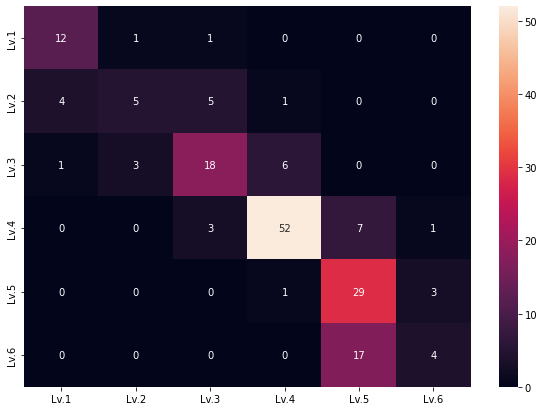

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(array, index = le.classes_.tolist(),
                  columns = le.classes_.tolist())
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show();

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true_list, y_pred_list, target_names=le.classes_.tolist()))

              precision    recall  f1-score   support

        Lv.1       0.71      0.86      0.77        14
        Lv.2       0.56      0.33      0.42        15
        Lv.3       0.67      0.64      0.65        28
        Lv.4       0.87      0.83      0.85        63
        Lv.5       0.55      0.88      0.67        33
        Lv.6       0.50      0.19      0.28        21

   micro avg       0.69      0.69      0.69       174
   macro avg       0.64      0.62      0.61       174
weighted avg       0.69      0.69      0.67       174

